In [1]:
import os
import pandas as pd 
import numpy as np 

# visualisation
import matplotlib.pylab as plt
import matplotlib.font_manager as fm

# our scripts 
import src.processing as sp 
import settings as st
import utils.helpers as hp
import utils.imaging as ui

### Correct for the locations of the images 

In [2]:
%%capture
!git pull

In [3]:
# dr5_desc = sp.correct_location('gz_decals_volunteers_5', save = True, filename='dr5_votes')

### The data with the votes

In [2]:
dataframe = hp.read_parquet(st.DATA_DIR, 'descriptions/dr5_votes')

In [3]:
labels = sp.generate_labels(dataframe, save=False)

In [4]:
labels.head()

,iauname,png_loc,Smooth,Featured or Disk,Artifact,Round,In Between,Cigar Shaped,Edge On Disk (Yes),Edge On Disk (No),...,Spiral Arms (2),Spiral Arms (3),Spiral Arms (4),Spiral Arms (More Than 4),Spiral Arms (cannot tell),Central Bulge (None),Central Bulge (Small),Central Bulge (Moderate),Central Bulge (Large),Central Bulge (Dominant)
0,J112953.88-000427.4,J112/J112953.88-000427.4.png,1,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,1,0,0
1,J104325.29+190335.0,J104/J104325.29+190335.0.png,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1
2,J104629.54+115415.1,J104/J104629.54+115415.1.png,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,1,1,0,0
3,J082950.68+125621.8,J082/J082950.68+125621.8.png,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,J122056.00-015022.0,J122/J122056.00-015022.0.png,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0


In [5]:
# labels.to_csv('ml/labels.csv')

# Calculate the weights per class

In [5]:
labels_num = labels.iloc[:,2:]
weights = labels_num.sum(axis=0)
inv_weights = 1/weights
inv_weights_norm = inv_weights/inv_weights.sum()

In [6]:
inv_weights_norm

Smooth                         0.002821
Featured or Disk               0.005690
Artifact                       0.057493
Round                          0.006431
In Between                     0.003816
Cigar Shaped                   0.011399
Edge On Disk (Yes)             0.010705
Edge On Disk (No)              0.003131
Merging (Merger)               0.024418
Merging (Major Disturbance)    0.041934
Merging (Minor Disturbance)    0.017971
Merging (None)                 0.002253
Bulge (Rounded)                0.008159
Bulge (Boxy)                   0.057669
Bulge (None)                   0.023825
No Bar                         0.003642
Weak Bar                       0.014607
Strong Bar                     0.029243
Spiral Arms (Yes)              0.006750
Spiral Arms (No)               0.004657
Spiral Winding (Tight)         0.010099
Spiral Winding (Medium)        0.013962
Spiral Winding (Loose)         0.020519
Spiral Arms (1)                0.055613
Spiral Arms (2)                0.009501


# Split into train, test and validate

In [8]:
train_val_test = sp.split_data(labels, 0.05, 0.15, save=False)

In [9]:
train_val_test['train'].shape

(202628, 36)

In [10]:
train_val_test['validate'].shape

(12665, 36)

In [11]:
train_val_test['test'].shape

(37993, 36)

In [12]:
labels.shape

(253286, 36)

### DataLoader

In [3]:
from src.dataset import DECaLSDataset
from torch.utils.data import Dataset, DataLoader

In [4]:
traindataset = DECaLSDataset(mode = 'train', augment = False, multi_task = True)

The number of training points is 189963


In [10]:
train_loader = DataLoader(dataset=traindataset, batch_size=4, shuffle=True)

In [11]:
dataiter = iter(train_loader)

In [12]:
data = dataiter.next()

In [20]:
sp.find_labels({'task_'+str(i+1): data[1][i][2].tolist() for i in range(10)})

array(['Featured or Disk', 'Edge On Disk (Yes)', 'Bulge (Rounded)',
       'Merging (None)'], dtype='<U27')

# Test Network

In [336]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# our scripts and functions
from src.network import MultiLabelNet, MultiTaskNet
from src.dataset import DECaLSDataset
import settings as st

In [337]:
out_path = './output/'
os.makedirs(out_path, exist_ok=True)

# Set device to CUDA if a CUDA device is available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create the dataloader
train_dataset = DECaLSDataset(mode='train', augment=False, multi_task = True)
val_dataset = DECaLSDataset(mode='validate', augment=False, multi_task = True)

train_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

The number of training points is 202628
The number of validation points is 12665


In [3]:
# %%capture
# model = MultiLabelNet(backbone="resnet18")
# model.to(device)

In [338]:
LABELS_PER_TASK = {'task_1': 3,
                   'task_2': 3,
                   'task_3': 2,
                   'task_4': 4,
                   'task_5': 3,
                   'task_6': 3,
                   'task_7': 2,
                   'task_8': 3,
                   'task_9': 6,
                   'task_10': 5
                   }

In [339]:
%%capture
model = MultiTaskNet(backbone="resnet18", output_size=LABELS_PER_TASK, resnet_task = True)
model.to(device)

In [6]:
data = next(iter(train_loader))

In [7]:
def criterion(loss, outputs: nn.ModuleDict, labels: dict) -> torch.tensor:
    losses = 0
    for i, key in enumerate(outputs):
        # print(outputs[key])
        # print(labels[key])
        losses += loss(outputs[key], labels[key].float().to(device))
    return losses

In [7]:
outputs = model(data[0].to(device))

In [8]:
outputs = model(data[0].to(device))
labels = data[1]
loss = nn.BCEWithLogitsLoss()
l = criterion(loss, outputs, labels)

# If We Want to Use Shared Representation

- Also implemented a ResNet in 1D. 

In [ ]:
import torch.nn.functional as F

In [26]:
tf_last_layer_chopped = nn.Sequential(*list(model.children())[:-1])

In [32]:
feat = tf_last_layer_chopped(data[0].to(device))

In [34]:
f = feat.to('cpu')

In [69]:
conv1 = nn.Conv1d(1, 1, kernel_size=3, stride=2, padding = (3 - 1)//2)
bn1 = nn.BatchNorm1d(1)
conv2 = nn.Conv1d(1, 1, kernel_size=3, stride=2, padding = (3 - 1)//2)
bn2 = nn.BatchNorm1d(1)

In [99]:
features = f.unsqueeze(1)

In [100]:
out = conv1(features)
out = bn1(out)
out = F.relu(out)
out = conv2(out)
out = bn2(out)

In [101]:
nout = out.shape[-1]
nfeat = features.shape[-1]
left = (1000 - nout) // 2
right = 1000 - left - nout

In [102]:
out = F.pad(input=out, pad=(left, right), mode='constant', value=0)

In [103]:
out += features
out = F.relu(out)

In [107]:
out = conv1(out)
out = bn1(out)
out = F.relu(out)
out = conv2(out)
out = bn2(out)

In [108]:
out.shape

torch.Size([4, 1, 250])

In [138]:
resnet_layer = nn.Sequential(*list(model.children())[:-1])

In [135]:
model_1 = nn.Sequential(*list(model.children())[1]['task_1'].layers[:-1])

In [137]:
# from torchsummary import summary
# summary(model, (1, 224, 224))

In [1]:
import os

In [2]:
os.path.join('a', 'b', 'c')

'a/b/c'

# Embedding Vector

In [74]:
import torch
import torch.nn as nn 
from src.network import MultiLabelNet
from src.dataset import DECaLSDataset
from torch.utils.data import DataLoader
import settings as st

import os
from PIL import Image
import matplotlib.pylab as plt

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [76]:
# load the model
%%capture
loaded_model = torch.load('../ml-models/resnet_18_multilabel_24.pth')
model = MultiLabelNet(backbone="resnet18")
model.to(device)
model.load_state_dict(loaded_model)
model.eval()

UsageError: Line magic function `%%capture` not found.


In [77]:
tf_last_layer_chopped = nn.Sequential(*list(model.children())[:-1])

In [78]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 50658


In [96]:
d1 = test_loader.dataset[0]
d2 = test_loader.dataset[1]
d3 = test_loader.dataset[2]
d4 = test_loader.dataset[3]

In [97]:
o1 = tf_last_layer_chopped(d1[0].view(1,1,224,224).to(device))
o2 = tf_last_layer_chopped(d2[0].view(1,1,224,224).to(device))
o3 = tf_last_layer_chopped(d3[0].view(1,1,224,224).to(device))
o4 = tf_last_layer_chopped(d4[0].view(1,1,224,224).to(device))

In [81]:
d1[1]

tensor([1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [82]:
d2[1]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [83]:
d3[1]

tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [98]:
d4[1]

tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

### Pairwise Distance

In [92]:
pdist = nn.PairwiseDistance(p=2)

In [93]:
pdist(o1, o2)

tensor([7.0306], device='cuda:0', grad_fn=<NormBackward1>)

In [94]:
pdist(o1, o3)

tensor([6.3318], device='cuda:0', grad_fn=<NormBackward1>)

In [95]:
pdist(o2, o3)

tensor([7.0053], device='cuda:0', grad_fn=<NormBackward1>)

In [103]:
pdist(o1, o4)

tensor([8.2538], device='cuda:0', grad_fn=<NormBackward1>)

In [104]:
pdist(o2, o4)

tensor([9.2016], device='cuda:0', grad_fn=<NormBackward1>)

In [105]:
pdist(o3, o4)

tensor([6.2826], device='cuda:0', grad_fn=<NormBackward1>)

### Cosine Similarity

In [84]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [85]:
cos(o1, o2)

tensor([0.5844], device='cuda:0', grad_fn=<DivBackward0>)

In [86]:
cos(o1, o3)

tensor([0.5753], device='cuda:0', grad_fn=<DivBackward0>)

In [87]:
cos(o2, o3)

tensor([0.5888], device='cuda:0', grad_fn=<DivBackward0>)

In [106]:
cos(o1, o4)

tensor([0.7079], device='cuda:0', grad_fn=<DivBackward0>)

In [107]:
cos(o2, o4)

tensor([0.6127], device='cuda:0', grad_fn=<DivBackward0>)

In [108]:
cos(o3, o4)

tensor([0.8876], device='cuda:0', grad_fn=<DivBackward0>)

In [101]:
test_dataset.desc.iloc[0:5]

,iauname,png_loc,smooth-or-featured_smooth_fraction,smooth-or-featured_featured-or-disk_fraction,smooth-or-featured_artifact_fraction,disk-edge-on_yes_fraction,disk-edge-on_no_fraction,has-spiral-arms_yes_fraction,has-spiral-arms_no_fraction,bar_strong_fraction,...,spiral-arm-count_1_fraction,spiral-arm-count_2_fraction,spiral-arm-count_3_fraction,spiral-arm-count_4_fraction,spiral-arm-count_more-than-4_fraction,spiral-arm-count_cant-tell_fraction,merging_none_fraction,merging_minor-disturbance_fraction,merging_major-disturbance_fraction,merging_merger_fraction
0,J140957.60+062506.1,J140/J140957.60+062506.1.png,1,0,0,0,1,1,0,1,...,0,1,0,0,0,0,1,0,0,0
1,J164313.15+261827.0,J164/J164313.15+261827.0.png,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,J150934.55+045229.1,J150/J150934.55+045229.1.png,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,J113334.66-021647.5,J113/J113334.66-021647.5.png,0,1,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,J101906.78+231837.7,J101/J101906.78+231837.7.png,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1


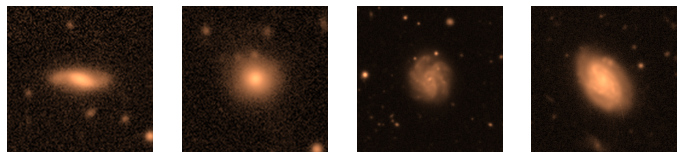

In [119]:
name = 'copper'
plt.figure(figsize = (12, 8))
plt.subplot(141)
plt.imshow(d1[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(142)
plt.imshow(d2[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(143)
plt.imshow(d3[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(144)
plt.imshow(d4[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')
plt.show()

# Pie Chart

- To repeat this for the entire dataset. 

In [22]:
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt 
import matplotlib as cm
import settings as st
import os 

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 25

In [23]:
dataframe = pd.read_csv('ml/labels.csv')

In [24]:
def calc_percent_task(table: pd.DataFrame, task_number: int = 1):
    
    # sum across columns
    column_sum = table[st.LABELS['task_' + str(task_number)]].sum(0)
    
    # calculate percentage
    percentage = column_sum / column_sum.sum() * 100
    
    return percentage

In [25]:
test = [calc_percent_task(dataframe, i + 1) for i in range(10)]

In [26]:
def plot_pie(index: int = 0, save: bool = False):
    nobject = len(test[index].values)
    colors = iter([plt.cm.Pastel1(k) for k in range(nobject)])
    fig1, ax1 = plt.subplots(figsize=(12,12))
#     fig1.set_figheight(8)
#     fig1.set_figwidth(8)
    patches, texts, autotexts = ax1.pie(test[index].values, labels=test[index].keys(), autopct='%1.1f%%', shadow=False, colors = colors)
    plt.setp(texts, fontsize=fontSize)
    plt.setp(autotexts, fontsize=fontSize)

    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    ax1.axis('equal') 
    
    if save:
        path = 'plots/pie/'
        os.makedirs(path, exist_ok=True)
        plt.savefig(path + 'pie_' + str(index) + '.pdf', bbox_inches = 'tight')
        plt.savefig(path + 'pie_' + str(index) + '.png', bbox_inches = 'tight')
        plt.close()
        
    else:
        plt.show()

In [27]:
# for i in range(10):
#     plot_pie(i, True)

In [1]:
import settings as st 
import utils.helpers as hp
import src.processing as sp
import pandas as pd
import numpy as np 

from src.dataset import DECaLSDataset
from torch.utils.data import DataLoader

import matplotlib.pylab as plt 
import matplotlib as cm

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 25

# Predictions from ML network

To rerun experiments on this using latest test set. 

In [13]:
preds = hp.load_csv('results', 'ML_predictions_class')
test = hp.load_csv('ml', 'test')

In [14]:
preds.shape

(37993, 34)

In [15]:
test.shape

(37993, 36)

In [12]:
test.head(10)

,iauname,png_loc,Smooth,Featured or Disk,Artifact,Round,In Between,Cigar Shaped,Edge On Disk (Yes),Edge On Disk (No),...,Spiral Arms (2),Spiral Arms (3),Spiral Arms (4),Spiral Arms (More Than 4),Spiral Arms (cannot tell),Central Bulge (None),Central Bulge (Small),Central Bulge (Moderate),Central Bulge (Large),Central Bulge (Dominant)
0,J140750.54+151031.7,J140/J140750.54+151031.7.png,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1,J135718.46+250352.5,J135/J135718.46+250352.5.png,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,J091543.01+300914.0,J091/J091543.01+300914.0.png,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,J081848.46+054220.7,J081/J081848.46+054220.7.png,0,1,0,0,1,0,0,1,...,1,0,0,0,0,1,1,0,1,0
4,J131316.58+093030.6,J131/J131316.58+093030.6.png,0,1,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
5,J155439.38+000214.4,J155/J155439.38+000214.4.png,1,0,0,0,1,0,0,1,...,1,0,0,0,0,0,1,0,0,0
6,J101912.87+024415.1,J101/J101912.87+024415.1.png,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
7,J144505.58+151136.6,J144/J144505.58+151136.6.png,1,1,0,0,1,0,0,1,...,1,0,0,0,1,1,1,0,0,0
8,J222644.99+161058.0,J222/J222644.99+161058.0.png,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
9,J101304.00-023934.0,J101/J101304.00-023934.0.png,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
preds.head(10)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34
0,0,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,1,0,0,0
1,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
5,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
7,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
8,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
9,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


# Predictions from MTL Network

In [2]:
def labels_test(test: pd.DataFrame, index: int = 0):
    
    # the first two column names are the name and png locations
    labels = test.iloc[index, 2:]
    
    label_dict = dict()
    for i in range(st.NUM_TASKS):
        task = labels[st.LABELS['task_' + str(i + 1)]].values.astype(int)
        label_dict['task_' + str(i + 1)] = task
        
    return label_dict

Load the predictions

In [3]:
preds = hp.load_pickle('results', 'MTL_predictions_mtl-models-2022-6-2')

In [4]:
pd.DataFrame(preds).head(10)

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
0,"[0, 1, 0]","[1, 0, 0]","[0, 1]","[0, 0, 0, 1]","[0, 1, 0]","[1, 0, 0]","[1, 0]","[0, 1, 0]","[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
1,"[1, 0, 0]","[1, 0, 0]","[0, 1]","[0, 0, 0, 1]","[1, 0, 0]","[1, 0, 0]","[0, 1]","[0, 1, 0]","[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
2,"[1, 0, 0]","[0, 1, 0]","[0, 1]","[0, 0, 1, 0]","[0, 1, 0]","[1, 0, 0]","[1, 0]","[0, 1, 0]","[0, 1, 0, 0, 0, 0]","[1, 0, 0, 0, 0]"
3,"[1, 0, 0]","[0, 0, 1]","[0, 1]","[0, 0, 0, 1]","[0, 0, 1]","[0, 1, 0]","[1, 0]","[0, 1, 0]","[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
4,"[1, 0, 0]","[1, 0, 0]","[0, 1]","[0, 0, 0, 1]","[1, 0, 0]","[1, 0, 0]","[1, 0]","[0, 1, 0]","[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
5,"[1, 0, 0]","[0, 1, 0]","[0, 1]","[0, 0, 0, 1]","[0, 0, 1]","[1, 0, 0]","[0, 1]","[0, 1, 0]","[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
6,"[1, 0, 0]","[1, 0, 0]","[0, 1]","[1, 0, 0, 0]","[1, 0, 0]","[1, 0, 0]","[0, 1]","[0, 1, 0]","[0, 1, 0, 0, 0, 0]","[0, 0, 1, 0, 0]"
7,"[1, 0, 0]","[0, 1, 0]","[0, 1]","[0, 0, 1, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0]","[0, 1, 0]","[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
8,"[1, 0, 0]","[0, 1, 0]","[0, 1]","[0, 0, 1, 0]","[1, 0, 0]","[1, 0, 0]","[0, 1]","[0, 1, 0]","[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
9,"[1, 0, 0]","[0, 1, 0]","[0, 1]","[0, 0, 0, 1]","[1, 0, 0]","[1, 0, 0]","[0, 1]","[0, 1, 0]","[0, 1, 0, 0, 0, 0]","[0, 0, 1, 0, 0]"


Load the test set

In [5]:
test = hp.load_csv('ml', 'test')
ntest = test.shape[0]

In [6]:
test.head(10)

,iauname,png_loc,Smooth,Featured or Disk,Artifact,Round,In Between,Cigar Shaped,Edge On Disk (Yes),Edge On Disk (No),...,Spiral Arms (2),Spiral Arms (3),Spiral Arms (4),Spiral Arms (More Than 4),Spiral Arms (cannot tell),Central Bulge (None),Central Bulge (Small),Central Bulge (Moderate),Central Bulge (Large),Central Bulge (Dominant)
0,J140750.54+151031.7,J140/J140750.54+151031.7.png,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1,J135718.46+250352.5,J135/J135718.46+250352.5.png,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,J091543.01+300914.0,J091/J091543.01+300914.0.png,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,J081848.46+054220.7,J081/J081848.46+054220.7.png,0,1,0,0,1,0,0,1,...,1,0,0,0,0,1,1,0,1,0
4,J131316.58+093030.6,J131/J131316.58+093030.6.png,0,1,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
5,J155439.38+000214.4,J155/J155439.38+000214.4.png,1,0,0,0,1,0,0,1,...,1,0,0,0,0,0,1,0,0,0
6,J101912.87+024415.1,J101/J101912.87+024415.1.png,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
7,J144505.58+151136.6,J144/J144505.58+151136.6.png,1,1,0,0,1,0,0,1,...,1,0,0,0,1,1,1,0,0,0
8,J222644.99+161058.0,J222/J222644.99+161058.0.png,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
9,J101304.00-023934.0,J101/J101304.00-023934.0.png,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
pred_bin = [np.vstack([preds[i]['task_'+str(j+1)] for i in range(ntest)]) for j in range(10)]
pred_bin = np.concatenate(pred_bin, axis = 1)
test_bin = test.iloc[:,2:].values

In [11]:
import sklearn.metrics as sm

In [12]:
for i in range(34):
    hl = sm.hamming_loss(test_bin[:,i], pred_bin[:,i])
    print(f'Class {i+1:2d}: {hl:.3f}')

Class  1: 0.147
Class  2: 0.169
Class  3: 0.029
Class  4: 0.171
Class  5: 0.215
Class  6: 0.077
Class  7: 0.142
Class  8: 0.284
Class  9: 0.092
Class 10: 0.055
Class 11: 0.159
Class 12: 0.191
Class 13: 0.451
Class 14: 0.332
Class 15: 0.179
Class 16: 0.418
Class 17: 0.216
Class 18: 0.110
Class 19: 0.167
Class 20: 0.437
Class 21: 0.185
Class 22: 0.850
Class 23: 0.094
Class 24: 0.086
Class 25: 0.754
Class 26: 0.030
Class 27: 0.013
Class 28: 0.011
Class 29: 0.130
Class 30: 0.111
Class 31: 0.310
Class 32: 0.388
Class 33: 0.170
Class 34: 0.073


In [13]:
for i, idx in enumerate(test.columns[2:]):
    print(f'Class {i+1:2d}: {idx}')

Class  1: Smooth
Class  2: Featured or Disk
Class  3: Artifact
Class  4: Round
Class  5: In Between
Class  6: Cigar Shaped
Class  7: Edge On Disk (Yes)
Class  8: Edge On Disk (No)
Class  9: Merging (Merger)
Class 10: Merging (Major Disturbance)
Class 11: Merging (Minor Disturbance)
Class 12: Merging (None)
Class 13: Bulge (Rounded)
Class 14: Bulge (Boxy)
Class 15: Bulge (None)
Class 16: No Bar
Class 17: Weak Bar
Class 18: Strong Bar
Class 19: Spiral Arms (Yes)
Class 20: Spiral Arms (No)
Class 21: Spiral Winding (Tight)
Class 22: Spiral Winding (Medium)
Class 23: Spiral Winding (Loose)
Class 24: Spiral Arms (1)
Class 25: Spiral Arms (2)
Class 26: Spiral Arms (3)
Class 27: Spiral Arms (4)
Class 28: Spiral Arms (More Than 4)
Class 29: Spiral Arms (cannot tell)
Class 30: Central Bulge (None)
Class 31: Central Bulge (Small)
Class 32: Central Bulge (Moderate)
Class 33: Central Bulge (Large)
Class 34: Central Bulge (Dominant)


### Iterate over all objects

In [14]:
ntest = test.shape[0]
tree_pred = list()
tree_test = list()

for idx in range(ntest):
    
    # re-write the test point in a dictionary (label per task)
    test_point = labels_test(test, idx)
          
    # find the labels (ground truths and test point)
    pred_labels = sp.find_labels(preds[idx])
    test_labels = sp.find_labels(test_point)
    
    # record the trees
    tree_pred.append(pred_labels)
    tree_test.append(test_labels)

In [15]:
tree_pred_df = pd.concat(tree_pred)
tree_test_df = pd.concat(tree_test)

In [16]:
tree_pred_df.reset_index(drop=True, inplace=True)
tree_test_df.reset_index(drop=True, inplace=True)

Save the outputs

In [17]:
# tree_pred_df.to_csv('results/tree_pred_2022_6_2.csv', index=False)
# tree_test_df.to_csv('results/tree_test_2022_6_2.csv', index=False)

# Visualise Image and Tree

In [18]:
import pandas as pd 
import sklearn.metrics as sm

In [19]:
tree_pred_df = pd.read_csv('results/tree_pred_2022_6_2.csv')
tree_test_df = pd.read_csv('results/tree_test_2022_6_2.csv')

In [26]:
# idxs = [6510, 6511, 6512, 6513]
idxs = [6, 7, 8, 9]

In [27]:
tree_pred_df.iloc[idxs]

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
6,['Smooth'],['Round'],NaN,['Merging (Merger)'],NaN,NaN,NaN,NaN,NaN,NaN
7,['Smooth'],['In Between'],NaN,['Merging (Minor Disturbance)'],NaN,NaN,NaN,NaN,NaN,NaN
8,['Smooth'],['In Between'],NaN,['Merging (Minor Disturbance)'],NaN,NaN,NaN,NaN,NaN,NaN
9,['Smooth'],['In Between'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
tree_test_df.iloc[idxs]

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
6,['Smooth'],['Round'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN
7,"['Smooth', 'Featured or Disk']",['In Between'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN
8,['Featured or Disk'],NaN,['Edge On Disk (No)'],"['Merging (Merger)', 'Merging (Major Disturban...",NaN,['No Bar'],['Spiral Arms (No)'],NaN,NaN,['Central Bulge (None)']
9,['Smooth'],['In Between'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 37993


In [24]:
d1 = test_loader.dataset[idxs[0]]
d2 = test_loader.dataset[idxs[1]]
d3 = test_loader.dataset[idxs[2]]
d4 = test_loader.dataset[idxs[3]]

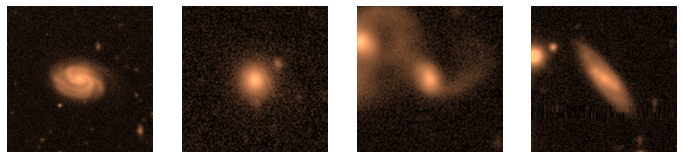

In [25]:
name = 'copper'
plt.figure(figsize = (12, 8))
plt.subplot(141)
plt.imshow(d1[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(142)
plt.imshow(d2[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(143)
plt.imshow(d3[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(144)
plt.imshow(d4[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')
plt.show()

### Count number of labels per task in the test set

In [73]:
def count_element(dataframe, task):
    
    ntest = dataframe.shape[0]
    
    record = []
    
    for i in range(ntest):
        
        element = dataframe[task].values[i]
        
        if not pd.isna(element):
            count = len(eval(element))
            
        else:
            count = 0 
            
        record.append(count)
        
    return pd.DataFrame(record, columns = [task])

In [78]:
tree_test_counts = []

for i in range(10):
    tree_test_counts.append(count_element(tree_test_df, 'task_'+str(i+1)))

In [79]:
tree_test_counts = pd.concat(tree_test_counts, axis = 1)

Select rows which has only one element

In [101]:
subset_test = tree_test_df[(tree_test_counts <= 1).all(1)]
subset_pred = tree_pred_df[(tree_test_counts <= 1).all(1)]

subset_test.reset_index(drop=True, inplace=True)
subset_pred.reset_index(drop=True, inplace=True)

In [300]:
print(f'Number of examples where we have unique labels is {subset_test.shape[0]}')

Number of examples where we have unique labels is 28838


### Metrics for Multi-Task

Assign a specific label to the different labels

In [203]:
def process_element(dataframe):
    
    ntest = dataframe.shape[0]
    
    record = []
    
    for t in range(10):
        task = 'task_'+str(t+1)
        for i in range(ntest):

            element = dataframe[task].values[i]

            if not pd.isna(element):
                dataframe[task].iloc[i] = eval(element)[0]
        
    return dataframe

In [222]:
df_pred = subset_pred.copy()
df_test = subset_test.copy()

In [223]:
# process the dataframe
df_processed_pred = process_element(df_pred)
df_processed_test = process_element(df_test)

In [286]:
def overall_mapping(df_test, df_pred):
    
    mapping = {}
    
    count = 1
    
    for t in range(10):
        for l in st.LABELS['task_'+str(t+1)]:
            mapping[l] = count
            count += 1
            
    df_pred_mapped = df_pred.applymap(lambda s: mapping.get(s) if s in mapping else s) 
    df_test_mapped = df_test.applymap(lambda s: mapping.get(s) if s in mapping else s)
    
    df_pred_mapped = df_pred_mapped.fillna(0)
    df_test_mapped = df_test_mapped.fillna(0)

    df_pred_mapped = df_pred_mapped.astype(int)
    df_test_mapped = df_test_mapped.astype(int)
    
    return df_test_mapped, df_pred_mapped

In [257]:
def hamming_per_task(df_test, df_pred, task):
    
    # build the mapping 
    mapping = {st.LABELS[task][i]: i+1 for i in range(len(st.LABELS[task]))}
       
    df_pred_mapped = df_pred[task].map(mapping)
    df_test_mapped = df_test[task].map(mapping)
    
    df_pred_mapped = df_pred_mapped.fillna(0)
    df_test_mapped = df_test_mapped.fillna(0)
    
    df_pred_mapped = df_pred_mapped.astype(int)
    df_test_mapped = df_test_mapped.astype(int)
    
    ham_loss = hamming_loss(df_test_mapped, df_pred_mapped)
    
    return ham_loss

In [258]:
for i in range(10):
    hl = hamming_per_task(df_processed_test, df_processed_pred, 'task_'+str(i+1))
    print(f'Task {i+1}: {hl:.3f}')

Task 1: 0.139
Task 2: 0.233
Task 3: 0.128
Task 4: 0.159
Task 5: 0.051
Task 6: 0.137
Task 7: 0.113
Task 8: 0.114
Task 9: 0.113
Task 10: 0.131


In [287]:
df1, df2 = overall_mapping(df_processed_test, df_processed_pred)

In [295]:
def metrics(df_test, df_pred):
    
    for i in range(10):
        task = 'task_'+str(i+1)
        
        acc = sm.accuracy_score(df_test[task], df_pred[task])
        ham = sm.hamming_loss(df_test[task], df_pred[task])
        pre = sm.precision_score(df_test[task], df_pred[task], average = "micro")
        rec = sm.recall_score(df_test[task], df_pred[task], average = "micro")
        f_1 = sm.f1_score(df_test[task], df_pred[task], average = "micro")
        
        print(f'Accuracy Score for Task {i+1}  : {acc:.3f}')
        print(f'Hamming Score for Task {i+1}   : {ham:.3f}')
        print(f'Precision Score for Task {i+1} : {pre:.3f}')
        print(f'Recall Score for Task {i+1}    : {rec:.3f}')
        print(f'F1 Score for Task {i+1}        : {f_1:.3f}')
        print('-'*50)

In [296]:
metrics(df1, df2)

Accuracy Score for Task 1  : 0.861
Hamming Score for Task 1   : 0.139
Precision Score for Task 1 : 0.861
Recall Score for Task 1    : 0.861
F1 Score for Task 1        : 0.861
--------------------------------------------------
Accuracy Score for Task 2  : 0.767
Hamming Score for Task 2   : 0.233
Precision Score for Task 2 : 0.767
Recall Score for Task 2    : 0.767
F1 Score for Task 2        : 0.767
--------------------------------------------------
Accuracy Score for Task 3  : 0.872
Hamming Score for Task 3   : 0.128
Precision Score for Task 3 : 0.872
Recall Score for Task 3    : 0.872
F1 Score for Task 3        : 0.872
--------------------------------------------------
Accuracy Score for Task 4  : 0.841
Hamming Score for Task 4   : 0.159
Precision Score for Task 4 : 0.841
Recall Score for Task 4    : 0.841
F1 Score for Task 4        : 0.841
--------------------------------------------------
Accuracy Score for Task 5  : 0.949
Hamming Score for Task 5   : 0.051
Precision Score for Task 5

# Number of Similar Trees

In [297]:
x = df1 == df2

In [298]:
frac = sum(x.all(1) * 1) / x.shape[0] * 100

print(f'Percentage of similar trees is {frac:.2f}')

Percentage of similar trees is 56.18


# Representations

In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# our scripts and functions
from src.network import MultiLabelNet, MultiTaskNet
from src.dataset import DECaLSDataset
import settings as st

import matplotlib.pylab as plt 
import matplotlib as cm

# plt.rc('text', usetex=True)
# plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
# figSize  = (12, 8)
# fontSize = 25

In [20]:
tree_pred_df = pd.read_csv('results/tree_pred.csv')
tree_test_df = pd.read_csv('results/tree_test.csv')

In [49]:
# tree_test_df[tree_test_df['task_1'] == "['Artifact']"]

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
# load the model
loaded_model = torch.load('../mtl-models/resnet_18_multitask_18.pth')
model = MultiTaskNet(backbone="resnet18", output_size=st.LABELS_PER_TASK, resnet_task=True)
model.to(device)
model.load_state_dict(loaded_model)

<All keys matched successfully>

In [35]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 37993


In [36]:
data = test_loader.dataset[412]

In [37]:
def representations(model, data):
    
    backbone = nn.Sequential(*list(model.children())[:-1])
    shared = backbone(data[0].view(1, 1, 224, 224).to(device))
    
    decoders = list(model.children())[1]
    
    dec = {}
    
    for k in range(10):
        task = 'task_' + str(k+1)
        model = nn.Sequential(*list(decoders[task].children())[:-1])
        dec[task] = model(shared.view(1, 1, 1000)).view(-1)
        
    return shared.view(-1), dec

In [38]:
fixed = representations(model, data)

In [39]:
pdist = nn.PairwiseDistance(p=2)

In [40]:
record = []

for i in range(37993):
    
    toAppend = {}
    
    ith_data = test_loader.dataset[i]
    
    shared, tasks = representations(model, ith_data)
    
    dist_shared = pdist(fixed[0], shared)
    
    toAppend['shared'] = dist_shared.item()
    
    for m in range(10):
        t = 'task_' + str(m + 1)
        dist_task = pdist(fixed[1][t], tasks[t])
        
        toAppend[t]= dist_task.item()

    record.append(toAppend)

In [41]:
distances_df = pd.DataFrame(record)

In [42]:
distances_df.sort_values(by=['shared']).head(10)

,shared,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
412,0.000032,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016
29310,1.235613,0.553905,0.624848,0.588287,0.543028,0.522510,0.556082,0.503247,0.542599,0.375840,0.504523
27644,1.256936,0.597060,0.626190,0.549091,0.575931,0.480167,0.552496,0.542654,0.496375,0.413801,0.509646
2321,1.266995,0.680314,0.712486,0.500529,0.609968,0.493514,0.607705,0.560549,0.581498,0.406113,0.570744
33605,1.272773,0.621829,0.657887,0.596962,0.609921,0.528535,0.612333,0.569649,0.539344,0.449902,0.552893
36111,1.275903,0.669533,0.664708,0.598438,0.527787,0.467860,0.582840,0.533597,0.483811,0.398207,0.548394
33272,1.316638,0.597452,0.695939,0.621969,0.591870,0.517066,0.593607,0.503542,0.584836,0.468041,0.519052
26192,1.316992,0.658251,0.674703,0.574814,0.555732,0.548993,0.687971,0.565201,0.557437,0.434887,0.580272
3884,1.318765,0.628982,0.682970,0.535639,0.586816,0.556882,0.626671,0.530337,0.580935,0.425289,0.579869
16839,1.331554,0.687595,0.659574,0.547028,0.611198,0.500210,0.644508,0.581222,0.536028,0.440493,0.669364


In [43]:
# distances_df.to_csv('results/distances_artifacts.csv')

### Load Distances

In [44]:
distances_df = pd.read_csv('results/distances_artifacts.csv').iloc[:,1:]

In [58]:
nobjects = 35

idxs = list(distances_df.sort_values(by=['shared']).head(nobjects).index)

In [59]:
# plt.imshow(test_loader.dataset[412][0].permute(1, 2, 0), cmap=plt.get_cmap(name))
# plt.axis('off')
# plt.show()

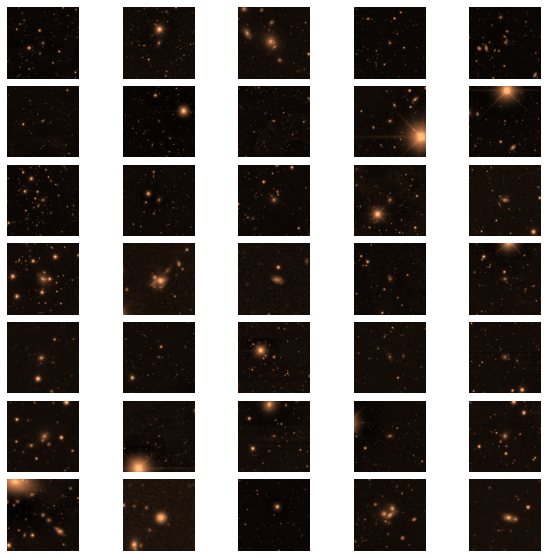

In [62]:
name = 'copper'
plt.figure(figsize = (10, 10))
for i in range(nobjects):
    plt.subplot(7, 5, i+1)
    plt.imshow(test_loader.dataset[idxs[i]][0].permute(1, 2, 0), cmap=plt.get_cmap(name))
    plt.axis('off')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
# plt.savefig('plots/neighbours_artifacts.pdf', bbox_inches = 'tight')
plt.show()